# Facial Age, Gender and Emotion Recognition - Custom Model
### Introduction
The aim of this project is to predict the age, gender and emotion of a person from an image of their face using artificial neural networks trained on images from the FER-2013 facial recognition dataset.

We investigate the accuracy of age, gender and emotion prediction using use different neural network models. We evaluate each model using accuracy, F1 score, L1 mean absolute error, and training time.

This notebook predicts facial age, gender and emotion using a custom neural network model.

In [ ]:
!pip install poutyne
!pip install torchsummary

In [1]:
import os
import tarfile
import urllib.request
import json
import collections

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from scipy.special import softmax
import seaborn as sn
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import torchvision.models as models
from torch.utils import model_zoo
from torch.utils.data import Subset, DataLoader, Dataset, random_split
from torchvision import transforms
from torchvision.datasets import ImageFolder, VisionDataset
from torchvision.utils import make_grid
from torchmetrics import MeanAbsoluteError

from poutyne import set_seeds, Model, ModelCheckpoint, CSVLogger, Experiment, BatchMetric, EarlyStopping, ReduceLROnPlateau
from zipfile import ZipFile
from torchsummary import summary
from PIL import Image

## Download and prepare the FER 2013 dataset

In [2]:
set_seeds(42)
base_path = './datasets/fer_2013'
zip_file_name = 'fer_2013.zip'
base_image_path = os.path.join(base_path, 'images')
zip_url = 'https://storage.googleapis.com/unsw_comp9444/fer_2103/fer_2013.zip'
train_json_url = 'https://storage.googleapis.com/unsw_comp9444/fer_2103/fer_faces_train.json'
test_json_url = 'https://storage.googleapis.com/unsw_comp9444/fer_2103/fer_faces_test.json'

emotion_classes = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
gender_classes = ['female', 'male']

#### Setup training constants

In [3]:
cuda_device = 0
device = torch.device("cuda:%d" % cuda_device if torch.cuda.is_available() else "cpu")
loss_weights={'age': 1/2100, 'gender': 1/2, 'emotion': 1/7}
batch_size = 32
test_batch_size = 128
learning_rate = 0.0001
weight_decay = 0.01
n_epoch = 70
max_age = 116
n_gender_classes = 2
n_emotion_classes = 7
image_size = 48 #original size of the image

#### Download and extract dataset images
Original dataset: https://www.kaggle.com/datasets/msambare/fer2013 \
Age, gender, emotion label train dataset: https://storage.googleapis.com/unsw_comp9444/fer_2103/fer_faces_train.json \
Age, gender, emotion label test dataset: https://storage.googleapis.com/unsw_comp9444/fer_2103/fer_faces_test.json

In [4]:
def download_and_extract_dataset(base_path, extract_path, file_name, zip_url, train_json_url, test_json_url):
    os.makedirs(base_path, exist_ok=True)
    os.makedirs(extract_path, exist_ok=True)
    zip_filename = os.path.join(base_path, file_name)
    train_json_filename = os.path.join(base_path, 'fer_faces_train.json')
    test_json_filename = os.path.join(base_path, 'fer_faces_test.json')

    print('Downloading dataset...')
    urllib.request.urlretrieve(zip_url, zip_filename)
    urllib.request.urlretrieve(train_json_url, train_json_filename)
    urllib.request.urlretrieve(test_json_url, test_json_filename)
    print('Extracting archive...')
    with ZipFile(zip_filename, 'r') as zip_obj:
       zip_obj.extractall(path=extract_path)
    
download_and_extract_dataset(base_path, base_image_path, zip_file_name, zip_url, train_json_url, test_json_url)    

Extracting archive...


#### Create Dataset for multi-task labelled face data

In [5]:
class FacesImageFolder(VisionDataset):        
    def __init__(self, root, labels_json_file, transform = None, target_transform = None, is_valid_file = None):
        super().__init__(root, transform=transform, target_transform=target_transform)
        self.labels_json_file = labels_json_file
        
        with open(self.labels_json_file, 'r') as f:
            self.labels_json = json.load(f)
            
        self.emotion_classes = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
        self.emotion_to_idx = {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}
        self.gender_classes = ['female', 'male']
        self.gender_to_idx = {'female': 0, 'male': 1}
        
    def __getitem__(self, index):
        label_json = self.labels_json[index]
    
        age = label_json['age']
        age_idx = int(age / 5)
        gender = label_json['gender']['value'].lower()
        emotion = label_json['emotion'].lower()
        image_path = label_json['imagePath']

        path = os.path.join(self.root, image_path)
        sample = self.loader(path)
        
        if self.transform is not None:
            sample = self.transform(sample)
            
        return sample, (torch.FloatTensor([age]), self.gender_to_idx[gender], self.emotion_to_idx[emotion])
    def __len__(self):
        return len(self.labels_json)
    
    def loader(self, path):
        with open(path, "rb") as f:
            img = Image.open(f)
            return img.convert("RGB")    

#### Create datasets and image transforms

In [6]:
augment_transform = transforms.Compose(
    [                
        transforms.ToTensor(),
        transforms.RandomAffine(degrees = 5, translate = (0.1, 0.1), shear = 5),        
        transforms.RandomHorizontalFlip(),
        #transforms.RandomVerticalFlip(),
        #transforms.RandomPerspective(),   
        #transforms.RandomAdjustSharpness(sharpness_factor=2),
        #transforms.RandomAutocontrast(),
        transforms.Grayscale(1),
        transforms.Normalize((0.5,), (0.25,))
    ]
)

normalize_transform = transforms.Compose(
    [        
        transforms.Resize((image_size, image_size)),        
        transforms.ToTensor(),
        transforms.Grayscale(1),    
        transforms.Normalize((0.5,), (0.25,))
    ]
)

train_image_path = os.path.join(base_image_path, 'train')
train_labels_jons_path = os.path.join(base_path, 'fer_faces_train.json')
test_image_path = os.path.join(base_image_path, 'test')
test_labels_jons_path = os.path.join(base_path, 'fer_faces_test.json')

train_dataset = FacesImageFolder(
    base_image_path,
    train_labels_jons_path,
    transform=augment_transform,
    is_valid_file=lambda path: not os.path.split(path)[1].startswith('.'),
)

test_valid_dataset = FacesImageFolder(
    base_image_path,
    test_labels_jons_path,
    transform=normalize_transform,
    is_valid_file=lambda path: not os.path.split(path)[1].startswith('.'),
)

Use 50% of the test dataset for validation

In [7]:
test_dataset_size = int(len(test_valid_dataset) * 0.5)
dataset_lengths = [test_dataset_size, len(test_valid_dataset) - test_dataset_size]
test_dataset, valid_dataset = random_split(test_valid_dataset, dataset_lengths)

#### Example face images

C:\Users\shaun\AppData\Local\Temp/ipykernel_45076/3231426579.py:15: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


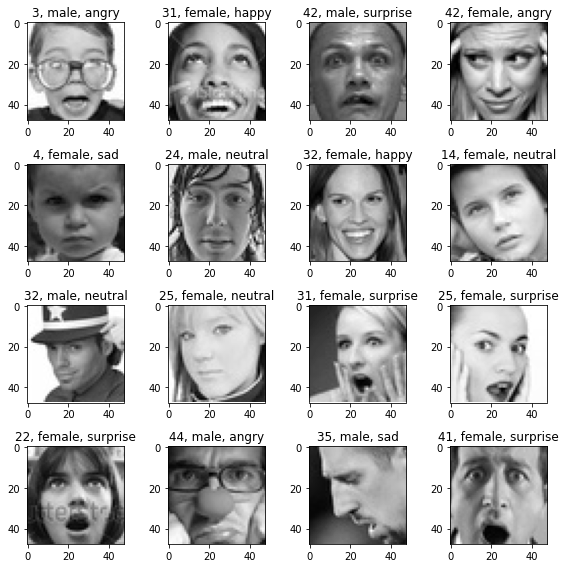

In [8]:
def show_batch(dataset):
    fig, ax = plt.subplots(4, 4, figsize=(8, 8))
    plt.subplots_adjust(wspace=0.3, hspace=0.3)
    for i, (image, label) in enumerate(dataset):
        gender = train_dataset.gender_classes[label[1]]
        emotion = train_dataset.emotion_classes[label[2]]
        age = int(label[0].item())

        ax[i % 4, i // 4].set_title(f'{age}, {gender}, {emotion}')
        ax[i % 4, i // 4].imshow(image.permute(1, 2, 0), cmap='gray')
        if i >= 15:
            break
            
    fig.tight_layout()
    fig.show()            
            
show_batch(test_dataset)          

#### Dataset sizes and classes

In [9]:
print(f'training dataset size: {len(train_dataset)}')
print(f'validaiton dataset size: {len(valid_dataset)}')
print(f'test dataset size: {len(test_dataset)}')

print(f'emotion classes: {train_dataset.emotion_classes}')
print(f'emotion class indexes: {train_dataset.emotion_to_idx}')

print(f'gender classes: {train_dataset.gender_classes}')
print(f'gender class indexes: {train_dataset.gender_to_idx}')

training dataset size: 28423
validaiton dataset size: 3555
test dataset size: 3555
emotion classes: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
emotion class indexes: {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}
gender classes: ['female', 'male']
gender class indexes: {'female': 0, 'male': 1}


#### Graph feature distributions

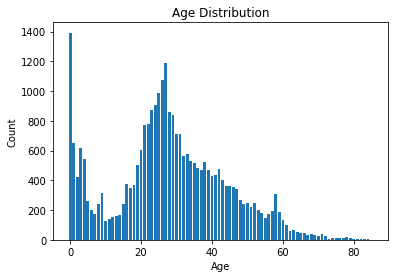

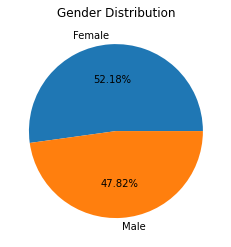

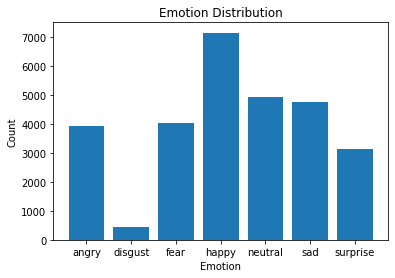

In [10]:
# Keep track of features in dataset
gender_count = {'Female': 0, 'Male': 0}
emotion_count = {'angry': 0, 'disgust': 0, 'fear': 0, 'happy': 0, 'neutral': 0, 'sad': 0, 'surprise': 0}
ages = []
total_elements = 0

# Loop through all of the data
for element in train_dataset.labels_json:
    # Get features from an individual element
    total_elements += 1        
    if element["gender"]["value"] == "Male":
        gender_count['Male'] += 1
    else:
        gender_count['Female'] += 1

    ages.append(element['age'])
    emotion_count[element['emotion']] += 1


# Calculate occurrence of each age and sort
ages_count = {}
for age in ages:
    if age in ages_count:
        ages_count[age] += 1
    else:
        ages_count[age] = 1

ages_count = collections.OrderedDict(sorted(ages_count.items()))


# Plot and save figures for each feature (age, gender, emotions)
age_names = list(ages_count.keys())
age_values = list(ages_count.values())
plt.bar(range(len(ages_count)), age_values)
plt.title("Age Distribution")
plt.xlabel('Age')
plt.ylabel('Count')
plt.savefig("plots/age_gender_emotion/age")
plt.show()

labels = list(gender_count.keys())
gender_values = list(gender_count.values())
plt.pie(gender_values, labels=labels, autopct='%1.2f%%')
plt.title("Gender Distribution")
plt.savefig("plots/age_gender_emotion/gender")
plt.show()

emotion_names = list(emotion_count.keys())
emotion_values = list(emotion_count.values())
plt.bar(range(len(emotion_count)), emotion_values, tick_label=emotion_names)
plt.title("Emotion Distribution")
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.savefig("plots/age_gender_emotion/emotion_distribution.png")
plt.show()

#### Create dataloaders for train, validation and test datasets

In [11]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, num_workers=0, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=test_batch_size, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=test_batch_size, num_workers=0)

## Create CNN model for facial age, gender and emotion recognition and classification

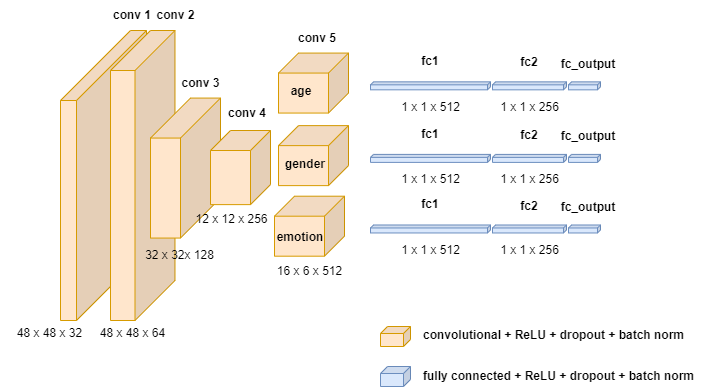

In [12]:
class AgeGenderEmotionNetork(nn.Module):
    
    def __init__(self):
        super(AgeGenderEmotionNetork, self).__init__()
        
        self.maxpool = nn.MaxPool2d(2, 2)
        
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding='same')    
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding='same')
        self.bn_conv1 = nn.BatchNorm2d(64)
        self.dropout_conv1 = nn.Dropout2d(0.25)
        
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding='same')
        self.bn_conv3 = nn.BatchNorm2d(128)
        self.dropout_conv3 = nn.Dropout2d(0.25)        
        
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding='same')
        self.bn_conv4 = nn.BatchNorm2d(256)
        self.dropout_conv4 = nn.Dropout2d(0.25)        
        
        self.conv5_age = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding='same')
        self.bn_conv5_age = nn.BatchNorm2d(512)    
        self.dropout_conv5_age = nn.Dropout2d(0.25)
        
        self.conv5_gender = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding='same')
        self.bn_conv5_gender = nn.BatchNorm2d(512)    
        self.dropout_conv5_gender = nn.Dropout2d(0.25)   
        
        self.conv5_emotion = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding='same')
        self.bn_conv5_emotion = nn.BatchNorm2d(512)    
        self.dropout_conv5_emotion = nn.Dropout2d(0.25)           
        
        self.fc1 = nn.Linear(4608, 256)
        self.bn_fc1 = nn.BatchNorm1d(256)
        self.dropout_fc1 = nn.Dropout(0.25)
        
        self.fc2 = nn.Linear(256, 512)
        self.bn_fc2 = nn.BatchNorm1d(512)
        self.dropout_fc2 = nn.Dropout(0.25)
        
        flatten_length = 4608
        self.fc1_age = nn.Linear(flatten_length, 512)
        self.bn_fc1_age = nn.BatchNorm1d(512)
        self.dropout_fc1_age = nn.Dropout(0.25)
        
        self.fc1_gender = nn.Linear(flatten_length, 512)
        self.bn_fc1_gender = nn.BatchNorm1d(512)
        self.dropout_fc1_gender = nn.Dropout(0.25)
        
        self.fc1_emotion = nn.Linear(flatten_length, 512)
        self.bn_fc1_emotion = nn.BatchNorm1d(512)
        self.dropout_fc1_emotion = nn.Dropout(0.25)
        
        self.fc2_age = nn.Linear(512, 256)
        self.bn_fc2_age = nn.BatchNorm1d(256)
        self.dropout_fc2_age = nn.Dropout(0.25)    
        
        self.fc2_gender = nn.Linear(512, 256)
        self.bn_fc2_gender = nn.BatchNorm1d(256)
        self.dropout_fc2_gender = nn.Dropout(0.25)
        
        self.fc2_emotion = nn.Linear(512, 256)
        self.bn_fc2_emotion = nn.BatchNorm1d(256)
        self.dropout_fc2_emotion = nn.Dropout(0.25)
        
        self.fc3_out_age = nn.Linear(256, 1)
        self.fc3_out_gender = nn.Linear(256, n_gender_classes)
        self.fc3_out_emotion = nn.Linear(256, n_emotion_classes)        
        
    def forward(self, input):    
        output = F.relu(self.conv1(input))      
        output = F.relu(self.conv2(output))
        output = self.bn_conv1(output)    
        output = self.maxpool(output)   
        output = self.dropout_conv1(output)
        
        output = F.relu(self.conv3(output))
        output = self.bn_conv3(output)    
        output = self.maxpool(output)   
        output = self.dropout_conv3(output)
        
        output = F.relu(self.conv4(output))
        output = self.bn_conv4(output)        
        output = self.maxpool(output)    
        output = self.dropout_conv4(output)
        
        output_age = F.relu(self.conv5_age(output))
        output_age = self.bn_conv5_age(output_age)
        output_age = self.maxpool(output_age)            
        output_age = self.dropout_conv5_age(output_age) 
        
        output_gender = F.relu(self.conv5_gender(output))
        output_gender = self.bn_conv5_gender(output_gender)
        output_gender = self.maxpool(output_gender)            
        output_gender = self.dropout_conv5_gender(output_gender)  
        
        output_emotion = F.relu(self.conv5_emotion(output))
        output_emotion = self.bn_conv5_emotion(output_emotion)
        output_emotion = self.maxpool(output_emotion)            
        output_emotion = self.dropout_conv5_emotion(output_emotion)          
        
        # Flattening process
        output_age = torch.flatten(output_age, start_dim=1)
        output_gender = torch.flatten(output_gender, start_dim=1)
        output_emotion = torch.flatten(output_emotion, start_dim=1)
                
        output_age = F.relu(self.fc1_age(output_age))
        output_age = self.bn_fc1_age(output_age)
        output_age = self.dropout_fc1_age(output_age)
        
        output_gender = F.relu(self.fc1_gender(output_gender))
        output_gender = self.bn_fc1_gender(output_gender)
        output_gender = self.dropout_fc1_gender(output_gender)   
        
        output_emotion = F.relu(self.fc1_emotion(output_emotion))
        output_emotion = self.bn_fc1_emotion(output_emotion)
        output_emotion = self.dropout_fc1_emotion(output_emotion)   
        
        output_age = F.relu(self.fc2_age(output_age))
        output_age = self.bn_fc2_age(output_age)
        output_age = self.dropout_fc2_age(output_age)        
        output_age = self.fc3_out_age(output_age)
        
        output_gender = F.relu(self.fc2_gender(output_gender))
        output_gender = self.bn_fc2_gender(output_gender)
        output_gender = self.dropout_fc2_gender(output_gender)        
        output_gender = self.fc3_out_gender(output_gender)
        
        output_emotion = F.relu(self.fc2_emotion(output_emotion))
        output_emotion = self.bn_fc2_emotion(output_emotion)
        output_emotion = self.dropout_fc2_emotion(output_emotion)        
        output_emotion = self.fc3_out_emotion(output_emotion)
        
        return output_age, output_gender, output_emotion
    
age_gender_emotion_netork = AgeGenderEmotionNetork().to(device)
print(summary(age_gender_emotion_netork, input_size=(1, image_size, image_size)))    

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 48, 48]             320
            Conv2d-2           [-1, 64, 48, 48]          18,496
       BatchNorm2d-3           [-1, 64, 48, 48]             128
         MaxPool2d-4           [-1, 64, 24, 24]               0
         Dropout2d-5           [-1, 64, 24, 24]               0
            Conv2d-6          [-1, 128, 24, 24]          73,856
       BatchNorm2d-7          [-1, 128, 24, 24]             256
         MaxPool2d-8          [-1, 128, 12, 12]               0
         Dropout2d-9          [-1, 128, 12, 12]               0
           Conv2d-10          [-1, 256, 12, 12]         295,168
      BatchNorm2d-11          [-1, 256, 12, 12]             512
        MaxPool2d-12            [-1, 256, 6, 6]               0
        Dropout2d-13            [-1, 256, 6, 6]               0
           Conv2d-14            [-1, 51

#### Create loss, accuracy and error functions for age, gender and emotion prediction

In [13]:
class AgeGenderEmotionLoss(nn.Module):
    def __init__(self, weights=None):
        super(AgeGenderEmotionLoss, self).__init__()           
        self.weights = weights
 
    def forward(self, inputs, targets, smooth=1):        
        cross_entropy_loss = nn.CrossEntropyLoss()
        mse_loss = nn.MSELoss()        
                
        [age_inputs, gender_inputs, emotion_inputs] = inputs
        [age_targets, gender_targets, emotion_targets] = targets    

        
        age_loss = mse_loss(age_inputs, age_targets)
        gender_loss = cross_entropy_loss(gender_inputs, gender_targets)
        emotion_loss = cross_entropy_loss(emotion_inputs, emotion_targets) 

        weighted_loss = age_loss * self.weights['age'] +  gender_loss * self.weights['gender'] + emotion_loss * self.weights['emotion']        
        return weighted_loss
    
class AgeGenderEmotionAccuracy(BatchMetric):
    def __init__(self, *, label='ALL'):
        super().__init__()
        self.label = label
        self.mean_absolute_error = MeanAbsoluteError()
        if label == 'ALL':
            self.__name__ = 'acc'
        else:
            self.__name__ = f'acc_{label}'
        
    def forward(self, y_pred, y_true):
        batch_size = y_pred[0].shape[0]
        [y_true_age, y_true_gender, y_true_emotion] = y_true
        [y_pred_age, y_pred_gender, y_pred_emotion] = y_pred
        
        y_pred_gender = y_pred_gender.argmax(1)
        y_pred_emotion = y_pred_emotion.argmax(1)
        
        acc_pre_age = 1 - (self.mean_absolute_error(y_pred_age, y_true_age) / max_age)
        acc_pred_gender = (y_pred_gender == y_true_gender).float()
        acc_pred_emotion = (y_pred_emotion == y_true_emotion).float()
    
        if self.label == 'ALL':
            acc_pred = (acc_pre_age + (acc_pred_gender.sum() / batch_size + acc_pred_emotion.sum() / batch_size)) / 3
        elif self.label == 'AGE':
            acc_pred = acc_pre_age
        elif self.label == 'GENDER':
            acc_pred = acc_pred_gender.sum() / batch_size
        elif self.label == 'EMOTION':
            acc_pred = acc_pred_emotion.sum() / batch_size
        
        return acc_pred      
    
class AgeMeanAbsoluteError(BatchMetric):
    def __init__(self):
        super().__init__()
        self.mean_absolute_error = MeanAbsoluteError()
        self.__name__ = f'mae_age'
        
    def forward(self, y_pred, y_true):
        batch_size = y_pred[0].shape[0]
        [y_true_age, _, _] = y_true
        [y_pred_age, _, _] = y_pred
        
        mae = self.mean_absolute_error(y_pred_age, y_true_age)
        
        return mae       

## Train the CNN for facial emotion classification on the FER 2013 dataset
#### Create training callbacks for saving last epoch, best epoch, reducing learning rate, early stopping and logging the results

In [14]:
save_base_dir = 'saves'
save_path = os.path.join(save_base_dir, 'fer_faces_age_gender_emotion')
os.makedirs(save_path, exist_ok=True)

plots_dir = 'plots/age_gender_emotion'
os.makedirs(plots_dir, exist_ok=True)

callbacks = [
    # Save the latest weights to be able to resume the optimization at the end for more epochs.
    ModelCheckpoint(os.path.join(save_path, 'last_epoch.ckpt')),
    # Save the weights in a new file when the current model is better than all previous models.
    ModelCheckpoint(
        os.path.join(save_path, 'best_epoch_{epoch}.ckpt'),
        monitor='val_acc',
        mode='max',
        save_best_only=True,
        restore_best=True,
        verbose=True,
    ),
    #EarlyStopping(patience=10, verbose=True),
    ReduceLROnPlateau(monitor='val_loss', verbose=True),       
    # Save the losses and accuracies for each epoch in a TSV.
    CSVLogger(os.path.join(save_path, 'log.tsv'), separator='\t'),
]

#### Create training optimizer, loss function and Poutyne model. Train the CNN network and evaluate validation and test datsets

In [1]:
optimizer = optim.Adam(age_gender_emotion_netork.parameters(), lr=learning_rate)

loss_function = AgeGenderEmotionLoss(loss_weights)

model = Model(
    age_gender_emotion_netork,
    optimizer,
    loss_function,
    batch_metrics=[AgeGenderEmotionAccuracy()],
    epoch_metrics=[AgeGenderEmotionAccuracy(label='AGE'), AgeGenderEmotionAccuracy(label='GENDER'), AgeGenderEmotionAccuracy(label='EMOTION'), AgeMeanAbsoluteError()],
    device=device,
)

model.fit_generator(
    train_loader,
    valid_loader,
    epochs=n_epoch,
    callbacks=callbacks    
)

test_loss, (test_acc), y_predict, y_true = model.evaluate_generator(test_loader, return_pred=True, return_ground_truth=True)

NameError: name 'optim' is not defined

## Print results, accuracy and confusion matrix

In [16]:
logs = pd.read_csv(os.path.join(save_path, 'log.tsv'), sep='\t')
print(logs)

best_epoch_idx = logs['val_acc'].idxmax()
best_epoch = int(logs.loc[best_epoch_idx]['epoch'])
print("Best epoch: %d" % best_epoch)

    epoch        time        lr      loss       acc   acc_AGE  acc_GENDER  \
0       1  160.887788  0.000100  1.113170  0.529909  0.755331    0.594835   
1       2  173.945802  0.000100  0.960197  0.578806  0.783563    0.634029   
2       3  167.590418  0.000100  0.754384  0.631253  0.842955    0.680892   
3       4  171.515629  0.000100  0.606036  0.674175  0.895374    0.717271   
4       5  164.343551  0.000100  0.543019  0.701152  0.913928    0.744432   
..    ...         ...       ...       ...       ...       ...         ...   
65     66  119.464697  0.000001  0.296861  0.830179  0.947597    0.880062   
66     67  123.553644  0.000001  0.294521  0.833281  0.947156    0.883897   
67     68  121.647936  0.000001  0.294036  0.830828  0.947467    0.883052   
68     69  122.292667  0.000001  0.295588  0.830171  0.948064    0.880203   
69     70  123.342238  0.000001  0.293538  0.831609  0.947664    0.884847   

    acc_EMOTION    mae_age  val_loss   val_acc  val_acc_AGE  val_acc_GENDER

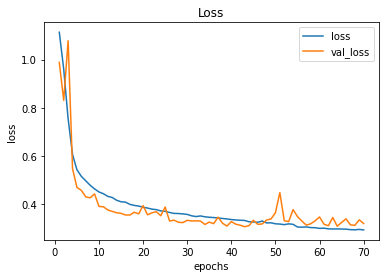

In [17]:
metrics = ['loss', 'val_loss']
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.plot(logs['epoch'], logs[metrics])
plt.legend(metrics)
plt.savefig('plots/age_gender_emotion/loss.png')
plt.show()

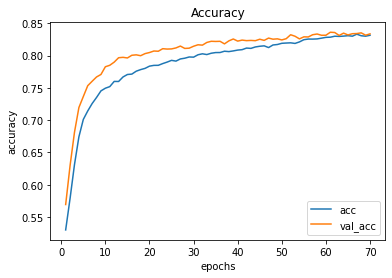

In [18]:
metrics = ['acc', 'val_acc']
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.plot(logs['epoch'], logs[metrics])
plt.legend(metrics)
plt.savefig('plots/age_gender_emotion/accuracy.png')
plt.show()

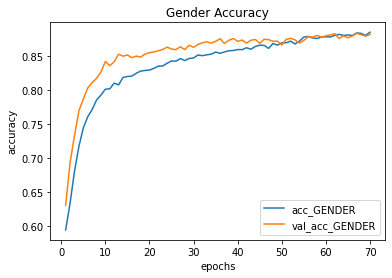

In [19]:
metrics = ['acc_GENDER', 'val_acc_GENDER']
plt.title('Gender Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.plot(logs['epoch'], logs[metrics])
plt.legend(metrics)
plt.savefig('plots/age_gender_emotion/gender_accuracy.png')
plt.show()

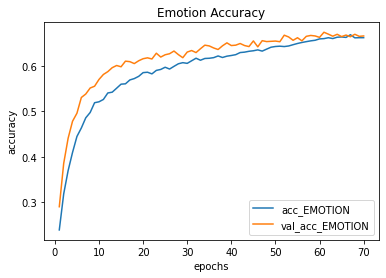

In [20]:
metrics = ['acc_EMOTION', 'val_acc_EMOTION']
plt.title('Emotion Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.plot(logs['epoch'], logs[metrics])
plt.legend(metrics)
plt.savefig('plots/age_gender_emotion/emotion_accuracy.png')
plt.show()

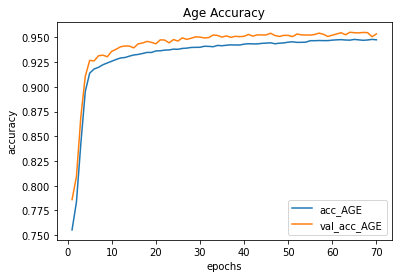

In [21]:
metrics = ['acc_AGE', 'val_acc_AGE']
plt.title('Age Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.plot(logs['epoch'], logs[metrics])
plt.legend(metrics)
plt.savefig('plots/age_gender_emotion/age_accuracy.png')
plt.show()

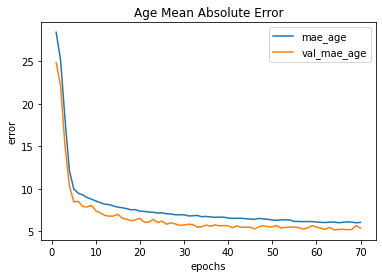

In [22]:
metrics = ['mae_age', 'val_mae_age']
plt.title('Age Mean Absolute Error')
plt.xlabel('epochs')
plt.ylabel('error')
plt.plot(logs['epoch'], logs[metrics])
plt.legend(metrics)
plt.savefig('plots/age_gender_emotion/age_mean_absolute_error.png')
plt.show()

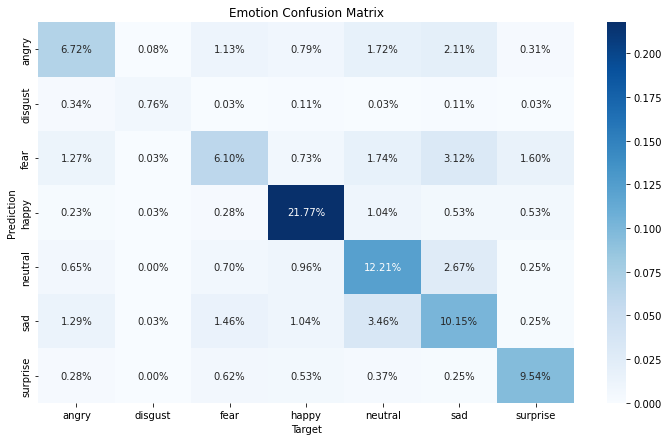

In [23]:
cf_matrix = confusion_matrix(y_true[2], np.argmax(y_predict[2], axis=1))
classes = list(train_dataset.emotion_classes)

plt.figure(figsize = (12,7))
plt.title('Emotion Confusion Matrix')
sn.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.savefig('plots/age_gender_emotion/emotion_confusion_matrix_emotion.png')
plt.xlabel('Target')
plt.ylabel('Prediction')

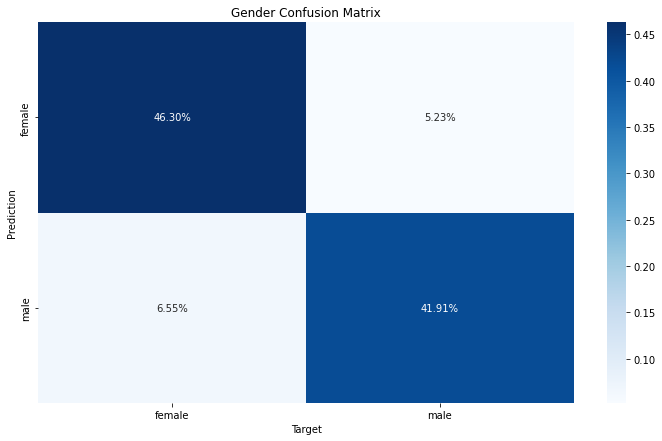

In [24]:
cf_matrix = confusion_matrix(y_true[1], np.argmax(y_predict[1], axis=1))
classes = list(train_dataset.gender_classes)
print()

plt.figure(figsize = (12,7))
plt.title('Gender Confusion Matrix')
sn.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.savefig('plots/age_gender_emotion/gender_confusion_matrix_emotion.png')
plt.xlabel('Target')
plt.ylabel('Prediction')
plt.show()

## Predict faces for demonstration

C:\Users\shaun\AppData\Local\Temp/ipykernel_28092/2256183553.py:28: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


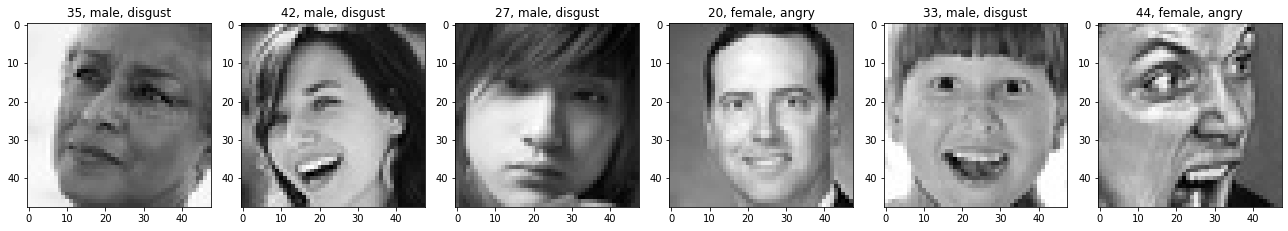

In [25]:
model.load_weights('./saves/fer_faces_age_gender_emotion/best_epoch_61.ckpt')

demo_dataset_size = 6
demo_dataset_splits = [demo_dataset_size, len(test_valid_dataset) - demo_dataset_size]
demo_dataset, _ = random_split(test_valid_dataset, demo_dataset_splits)

#demo_predictions = model.predict_dataset(test_valid_dataset, has_ground_truth=True)

fig, ax = plt.subplots(1, demo_dataset_size, figsize=(18, 4))
plt.subplots_adjust(wspace=0.3, hspace=0.3)

for i, (image, _) in enumerate(demo_dataset):        
        age = demo_predictions[0][i][0].astype(int) 
        
        gender_softmax = softmax(demo_predictions[1][i])
        gender_max_index = gender_softmax.argmax()
        gender_name = gender_classes[gender_max_index]
        
        emotion_softmax = softmax(demo_predictions[2][i])
        emotion_max_index = emotion_softmax.argmax()
        emotion_name = emotion_classes[gender_max_index] 
        
        ax[i].set_title(f'{age}, {gender_name}, {emotion_name}')
        ax[i].imshow(image.permute(1, 2, 0), cmap='gray')
        
fig.tight_layout()
plt.savefig('plots/age_gender_emotion/demo_predictions.png')        
fig.show()         